In [1]:
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit

In [2]:
# single-qubit rotations
exponents = np.linspace(0, 7/4, 8)
exponents

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

In [3]:
import itertools
SINGLE_QUBIT_GATES = [
    cirq.PhasedXZGate(x_exponent=0.5, z_exponent=z, axis_phase_exponent=a)
    for a, z in itertools.product(exponents, repeat=2)
]
SINGLE_QUBIT_GATES[:10], '...'

([cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.25),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.5),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.75),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.25),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.5),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.75),
  cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=0.5, z_exponent=0.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=0.5, z_exponent=0.25)],
 '...')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


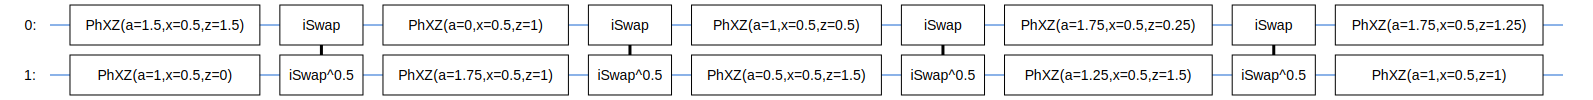

In [4]:
# random two-qubit circuit
import cirq_google as cg
from cirq.experiments import random_quantum_circuit_generation as rqcg

q0, q1 = cirq.LineQubit.range(2)
circuit = rqcg.random_rotations_between_two_qubit_circuit(
    q0, q1, 
    depth=4, 
    two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b), 
    single_qubit_gates=SINGLE_QUBIT_GATES
)
SVGCircuit(circuit)

In [5]:
# long circuits to truncate
MAX_DEPTH = 100
N_CIRCUITS = 10
circuits = [
    rqcg.random_rotations_between_two_qubit_circuit(
        q0, q1, 
        depth=MAX_DEPTH, 
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b), 
        single_qubit_gates=SINGLE_QUBIT_GATES)
    for _ in range(N_CIRCUITS)
]

In [6]:
# length to truncate
cycle_depths = np.arange(1, MAX_DEPTH + 1, 9)
cycle_depths

array([  1,  10,  19,  28,  37,  46,  55,  64,  73,  82,  91, 100])

In [7]:
pure_sim = cirq.Simulator()

# Pauli Error. If there is an error, it is either X, Y, or Z
# with probability E_PAULI / 3
E_PAULI = 5e-3
noisy_sim = cirq.DensityMatrixSimulator(noise=cirq.depolarize(E_PAULI))

# These two qubit circuits have 2^2 = 4 probabilities
DIM = 4

records = []
for cycle_depth in cycle_depths:
    for circuit_i, circuit in enumerate(circuits):

        # Truncate the long circuit to the requested cycle_depth
        circuit_depth = cycle_depth * 2 + 1
        assert circuit_depth <= len(circuit)
        trunc_circuit = circuit[:circuit_depth]

        # Pure-state simulation
        psi = pure_sim.simulate(trunc_circuit)
        psi = psi.final_state_vector
        pure_probs = np.abs(psi)**2

        # Noisy execution
        meas_circuit = trunc_circuit + cirq.measure(q0, q1)
        sampled_inds = noisy_sim.sample(meas_circuit, repetitions=10_000).values[:,0]
        sampled_probs = np.bincount(sampled_inds, minlength=DIM) / len(sampled_inds)

        # Save the results
        records += [{
            'circuit_i': circuit_i,
            'cycle_depth': cycle_depth,
            'circuit_depth': circuit_depth,
            'pure_probs': pure_probs,
            'sampled_probs': sampled_probs,
        }]
        print('.', end='', flush=True)

........................................................................................................................

In [8]:
for record in records:
    e_u = np.sum(record['pure_probs']**2)
    u_u = np.sum(record['pure_probs']) / DIM
    m_u = np.sum(record['pure_probs'] * record['sampled_probs'])
    record.update(
        e_u=e_u,
        u_u=u_u,
        m_u=m_u,    
    )

In [9]:
import pandas as pd
df = pd.DataFrame(records)
df['y'] = df['m_u'] - df['u_u']
df['x'] = df['e_u'] - df['u_u']

df['numerator'] = df['x'] * df['y']
df['denominator'] = df['x'] ** 2
df.head()

,circuit_i,cycle_depth,circuit_depth,pure_probs,sampled_probs,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,3,"[0.021446602, 0.72855335, 0.12499999, 0.12499998]","[0.0298, 0.7106, 0.1218, 0.1378]",0.562500,0.25,0.550799,0.300799,0.312500,0.094000,0.097656
1,1,1,3,"[0.12500001, 0.12499998, 0.021446602, 0.72855335]","[0.1226, 0.132, 0.0341, 0.7113]",0.562500,0.25,0.550776,0.300776,0.312500,0.093993,0.097656
2,2,1,3,"[0.56249994, 0.18749997, 0.18749997, 0.0625]","[0.5563, 0.1812, 0.1948, 0.0677]",0.390625,0.25,0.387650,0.137650,0.140625,0.019357,0.019775
3,3,1,3,"[0.72855335, 0.021446602, 0.12499998, 0.124999...","[0.7081, 0.0313, 0.1362, 0.1244]",0.562500,0.25,0.549135,0.299135,0.312500,0.093480,0.097656
4,4,1,3,"[0.68750006, 0.062499985, 0.062499985, 0.1875]","[0.68, 0.0728, 0.0736, 0.1736]",0.515625,0.25,0.509200,0.259200,0.265625,0.068850,0.070557


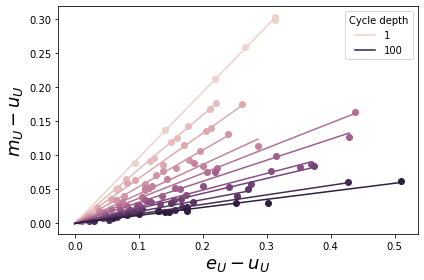

In [12]:
# plot the linear relationship and least squares fit
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns
colors = sns.cubehelix_palette(n_colors=len(cycle_depths))        
colors = {k: colors[i] for i, k in enumerate(cycle_depths)}

_lines = []
def per_cycle_depth(df):
    fid_lsq = df['numerator'].sum() / df['denominator'].sum()

    cycle_depth = df.name    
    xx = np.linspace(0, df['x'].max())
    l, = plt.plot(xx, fid_lsq*xx, color=colors[cycle_depth])
    plt.scatter(df['x'], df['y'], color=colors[cycle_depth])

    global _lines
    _lines += [l] # for legend
    return pd.Series({'fidelity': fid_lsq})

fids = df.groupby('cycle_depth').apply(per_cycle_depth).reset_index()
plt.xlabel(r'$e_U - u_U$', fontsize=18)
plt.ylabel(r'$m_U - u_U$', fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0,-1]], cycle_depths[[0,-1]], loc='best', title='Cycle depth')
plt.tight_layout()

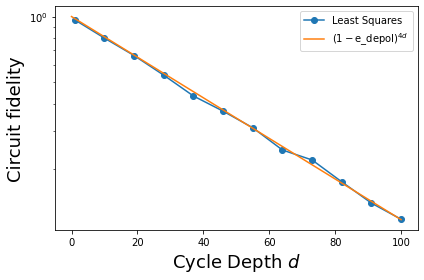

In [13]:
# fidelities
plt.plot(
    fids['cycle_depth'], 
    fids['fidelity'],
    marker='o',
    label='Least Squares')

xx = np.linspace(0, fids['cycle_depth'].max())

# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
e_depol = E_PAULI / (1 - 1/DIM**2)

# The additional factor of four in the exponent is because each layer
# involves two moments of two qubits (so each layer has four applications
# of a single-qubit single-moment depolarizing channel).
plt.plot(xx, (1-e_depol)**(4*xx), label=r'$(1-\mathrm{e\_depol})^{4d}$')

plt.ylabel('Circuit fidelity', fontsize=18)
plt.xlabel('Cycle Depth $d$', fontsize=18)
plt.legend(loc='best')
plt.yscale('log')
plt.tight_layout()

In [14]:
from cirq.experiments.xeb_fitting import fit_exponential_decays

# Ordinarily, we'd use this function to fit curves for multiple pairs.
# We add our qubit pair as a column.
fids['pair'] = [(q0, q1)] * len(fids)

fit_df = fit_exponential_decays(fids)
fit_row = fit_df.iloc[0]
print(f"Noise model fidelity: {(1-e_depol)**4:.3e}")
print(f"XEB layer fidelity:   {fit_row['layer_fid']:.3e} +- {fit_row['layer_fid_std']:.2e}")

Noise model fidelity: 9.788e-01
XEB layer fidelity:   9.789e-01 +- 2.01e-04
